# 🧪 Cytotoxicity & Hemolysis Plotter

This notebook allows you to upload `.xlsx` files and generate clean, consistent plots of **cytotoxicity** or **hemolysis** data.

---

## 🔍 Features:
- Reads molecule names dynamically from the file header
- Automatically groups replicates
- Detects controls (`CC`, `CM`, `CT`) if present and positions them accordingly
- Assigns each molecule a unique color and symbol
- Supports **optional anonymization** of peptide names
- Saves high-quality `.png` plots

---

## ⚙️ How to use:
1. Install dependencies (first cell).
2. Set `ANONYMIZE = True` if you want to anonymize peptide names.
3. Upload one or more `.xlsx` files using the upload cell.
4. Run the main analysis cell to generate and view the plots.


# 📦 Install dependencies

In [1]:
!pip install -q colorcet openpyxl


# ⚙️ Settings
If `ANONYMIZE = True`, peptide names were replaced by generic Peptide_1, Peptide_2, etc., while controls kept their names.

In [2]:
ANONYMIZE =  True  # Change to True to anonymize peptide names
CONTROL_IDS = {"CC", "CM", "CT"} # Adapt it to your controls


# 📚 Imports

In [3]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO


# 📁 Upload dataset files (Excel file expected as input)

In [4]:
uploaded = files.upload()


Saving datos_hemolisis_2.xlsx to datos_hemolisis_2.xlsx
Saving datos_pbmcs.xlsx to datos_pbmcs.xlsx
Saving datos_thp1.xlsx to datos_thp1.xlsx
Saving datos_vero.xlsx to datos_vero.xlsx


In [5]:

# 🔍 Clean helper
def clean_val(v):
    if isinstance(v, str) and (v.strip().endswith("*") or v.strip().startswith("_")):
        return np.nan
    return v


#🎨Plotting function

<ipython-input-6-42eddd0bcb98>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hdr = raw.iloc[0].fillna(method='ffill')
<ipython-input-6-42eddd0bcb98>:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda v: np.nan if isinstance(v, str) and (v.strip().endswith("*") or v.strip().startswith("_")) else v)
<ipython-input-6-42eddd0bcb98>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hdr = raw.iloc[0].fillna(method='ffill')
<ipython-input-6-42eddd0bcb98>:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda v: np.nan if isinstance(v, str) and (v.strip().endswith("*") or v.strip().startswith("_")) else v)
<ipython-input-6-42eddd0bcb98>:6: FutureWarning: Series.fillna with 'method' is deprecated and w

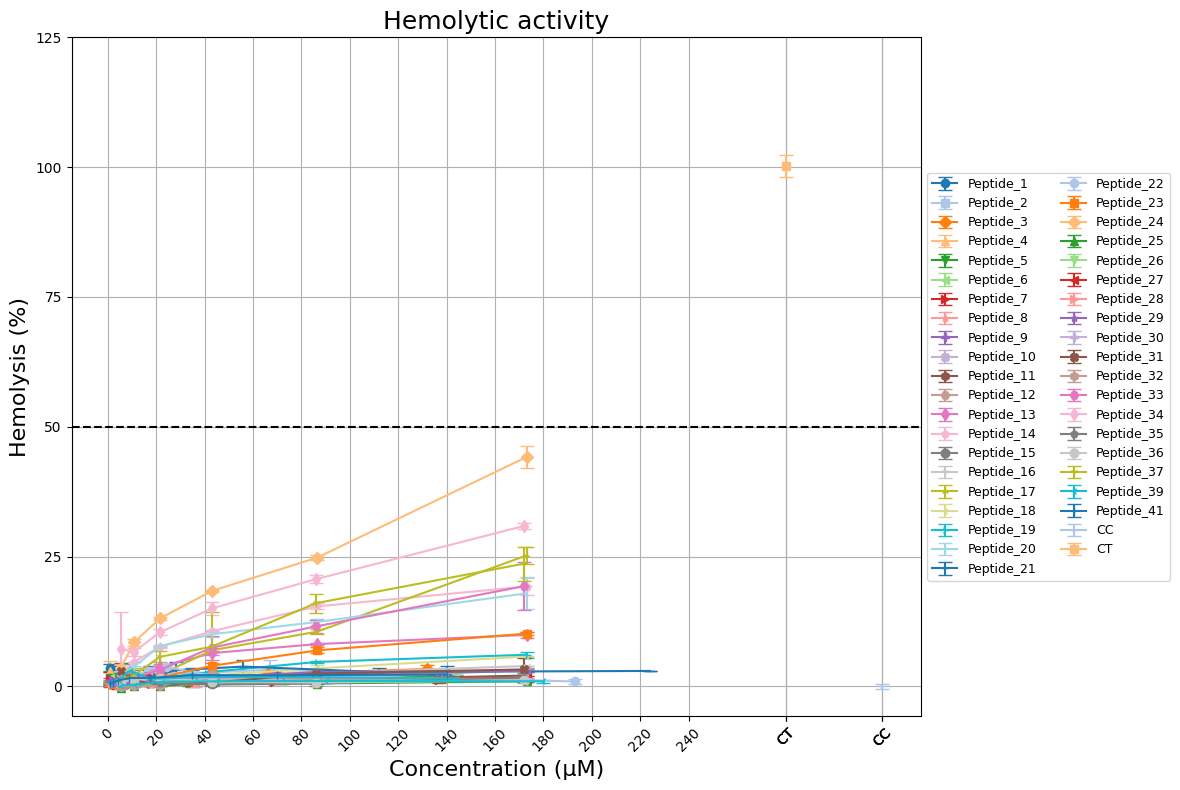

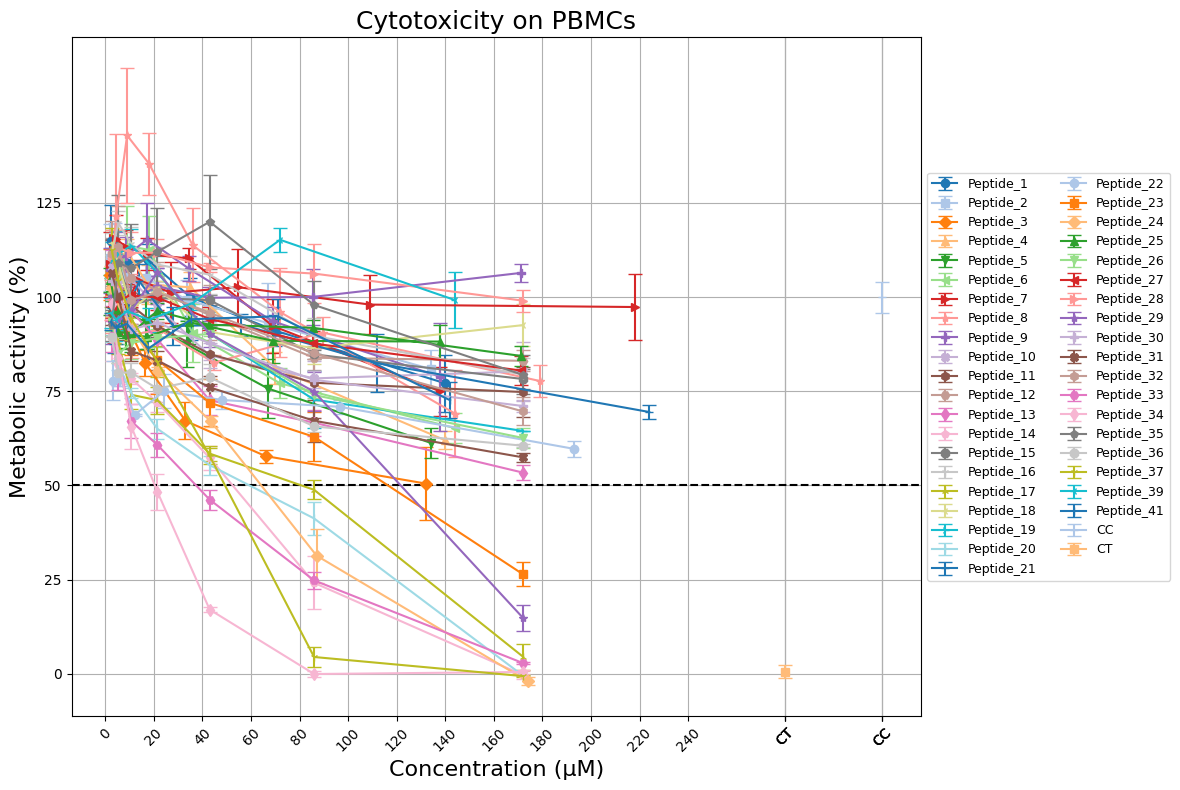

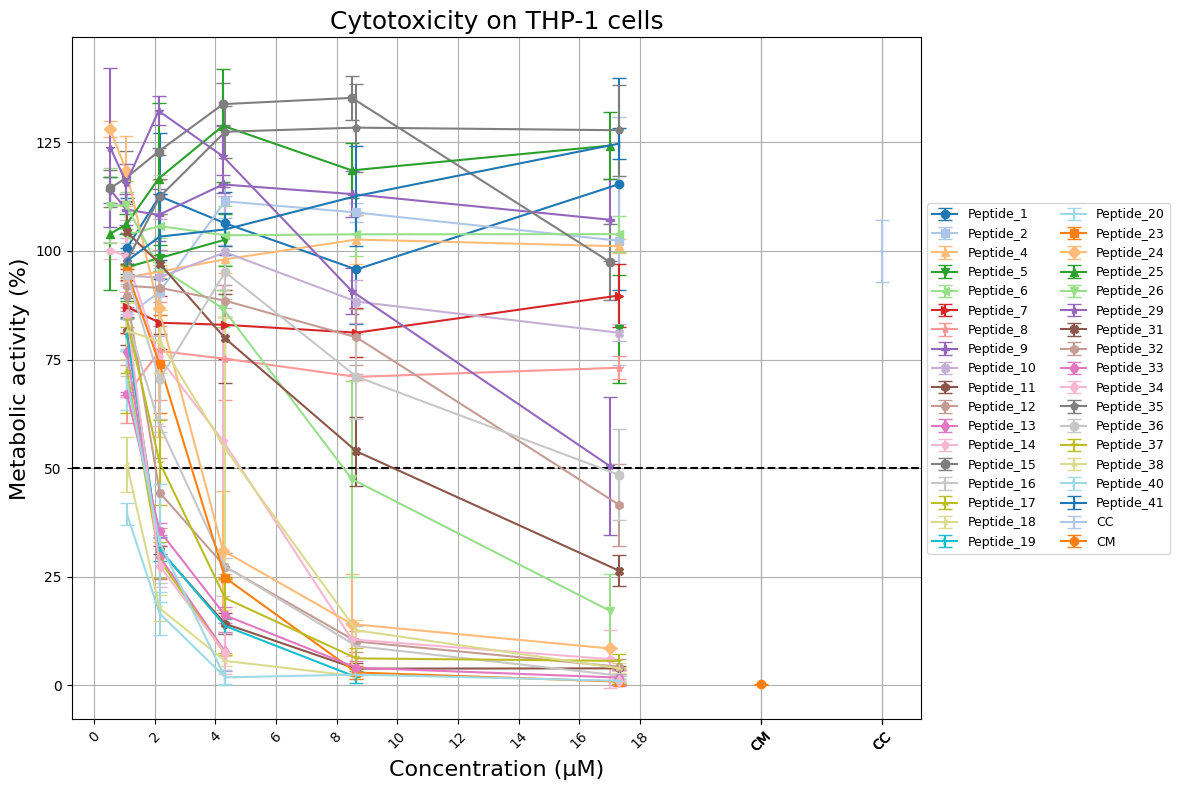

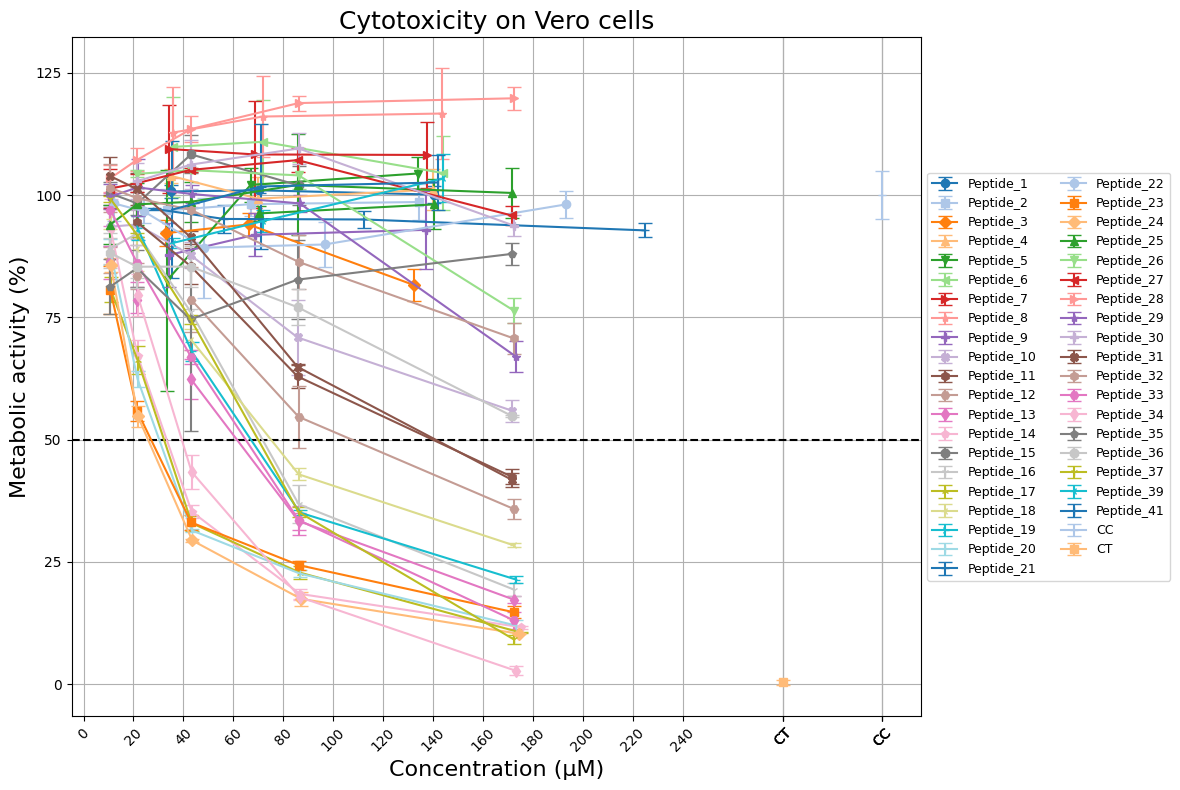

In [6]:

# ---------- Load files ----------
dataframes = {}

for name, file in uploaded.items():
    raw = pd.read_excel(BytesIO(file), header=None)
    hdr = raw.iloc[0].fillna(method='ffill')
    df = raw.copy()
    df.columns = ["Conc"] + hdr[1:].tolist()
    df = df.iloc[1:].reset_index(drop=True)
    df = df.applymap(lambda v: np.nan if isinstance(v, str) and (v.strip().endswith("*") or v.strip().startswith("_")) else v)
    df["Conc"] = pd.to_numeric(df["Conc"], errors='coerce')
    dataframes[name] = df

# ---------- Unique markers for each molecule and controls ----------
all_labels = set()
for df in dataframes.values():
    all_labels.update(df.columns[1:])

controls = {x for x in all_labels if x in CONTROL_IDS}
peptides = sorted(all_labels - controls)
ordered = peptides + sorted(controls)

MARKERS = ['o','s','D','^','v','<','>','*','P','X','h','H','d','p','8','1','2','3','4','|','_']
PALETTE = list(plt.cm.get_cmap("tab20").colors) * 10
STYLE_MAP = {name: (PALETTE[i % len(PALETTE)], MARKERS[i % len(MARKERS)]) for i, name in enumerate(ordered)}

# ---------- Anonymize if applies ----------
anon_map = {}
if ANONYMIZE:
    counter = 1
    for label in ordered:
        if label in CONTROL_IDS:
            anon_map[label] = label
        else:
            anon_map[label] = f"Peptide_{counter}"
            counter += 1
else:
    anon_map = {k: k for k in ordered}

# ---------- Plotting ----------
for filename, df in dataframes.items():
    max_c = df["Conc"].dropna().max() or 0
    tick = 2 if max_c < 20 else 20
    gap = tick * 2

    last_tick = (int(max_c // tick) + 1) * tick
    ctrl_pos = {}
    extra = last_tick
    for c in CONTROL_IDS:
        if c in df.columns:
            extra += gap
            ctrl_pos[c] = extra

    def unique(seq):
        seen = set()
        for x in seq:
            if x not in seen:
                seen.add(x)
                yield x

    peps, cols = {}, df.columns[1:]
    for p in unique(cols):
        grp = df.loc[:, cols[cols == p]].apply(pd.to_numeric, errors='coerce')
        if p in CONTROL_IDS:
            g = grp[df["Conc"].isna()]
            peps[p] = {"x": [ctrl_pos.get(p, extra)],
                       "y": [g.mean(axis=0).mean()],
                       "e": [np.nan_to_num(g.stack().std(), nan=0.0)]}
        else:
            peps[p] = {"x": df["Conc"].to_numpy(),
                       "y": grp.mean(axis=1).to_numpy(),
                       "e": np.nan_to_num(grp.std(axis=1).to_numpy(), nan=0.0)}

    plt.figure(figsize=(14,8))
    for p in ordered:
        if p not in peps: continue
        d = peps[p]
        col, mk = STYLE_MAP[p]
        label = anon_map[p]
        plt.errorbar(d["x"], d["y"], yerr=d["e"], fmt=f"{mk}-",
                     capsize=5, color=col, label=label)

    base = list(range(0, last_tick+tick, tick))
    pos = base + [ctrl_pos[c] for c in df.columns if c in CONTROL_IDS]
    lab = [str(x) for x in base] + [anon_map[c] for c in df.columns if c in CONTROL_IDS]
    plt.xticks(pos, lab, rotation=45)

    name = filename.lower()
    if "hemo" in name or "lysis" in name:
        ylab = "Hemolysis (%)"
        title = "Hemolytic activity"
    else:
        ylab = "Metabolic activity (%)"
        if "thp1" in name: title = "Cytotoxicity on THP-1 cells"
        elif "pbmc" in name: title = "Cytotoxicity on PBMCs"
        elif "vero" in name: title = "Cytotoxicity on Vero cells"
        else: title = "Cytotoxicity"

    plt.title(title, fontsize=18)
    plt.xlabel("Concentration (µM)", fontsize=16)
    plt.ylabel(ylab, fontsize=16)
    plt.yticks(range(0,126,25))
    plt.axhline(50, ls='--', c='k')
    plt.grid(True)

    handles, labels = plt.gca().get_legend_handles_labels()
    order = [labels.index(anon_map[p]) for p in ordered if p in peps]
    plt.legend([handles[i] for i in order], [labels[i] for i in order],
               loc='center left', bbox_to_anchor=(1,0.5), ncol=2, fontsize=9)

    plt.tight_layout(rect=[0,0,0.85,1])
    plt.savefig(filename.replace(".xlsx", "_cytotox.png"), dpi=300)
    plt.show()